In [3]:
import tensorflow as tf
import keras
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt 

from keras import layers, models, callbacks
from keras import optimizers, regularizers
from keras import losses, metrics
from keras.utils import plot_model
from keras.utils import serialize_keras_object, to_categorical

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [4]:
SEED = 42

---
# Завантажуємо датасет
---

In [5]:
# Завантаження датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 1. Нормалізація пікселів (0-255 -> 0-1)
x_train, x_test = (x_train / 255.0).astype("float32"), (x_test / 255.0).astype(
    "float32"
)

# 2. Поділ на train/val (10 % для валідації)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)


# 3. Функція для графіків
def plot_history(h, title=""):
    plt.plot(h.history["loss"], label="train loss")
    plt.plot(h.history["val_loss"], label="val loss")
    plt.plot(h.history["accuracy"], label="train acc")
    plt.plot(h.history["val_accuracy"], label="val acc")
    plt.title(title)
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(54000, 28, 28) (54000,)
(10000, 28, 28) (10000,)
(6000, 28, 28) (6000,)


In [7]:
# Список назв класів
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Виведення назви класу для першого зображення
index = 0  # Індекс зображення
print(f"Мітка: {y_train[index]}, Назва класу: {class_names[y_train[index]]}")

Мітка: 8, Назва класу: Bag


---
# Візуалізуємо зображення з нашого датасету:
---

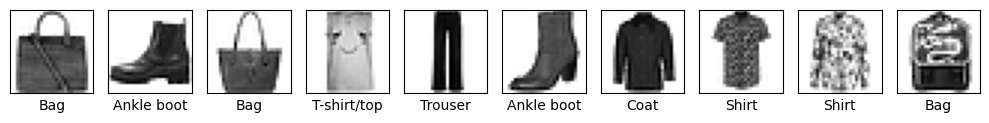

In [8]:
plt.figure(figsize=(10, 10))
# Цикл для відображення перших 10 зображень
for i in range(10):
    plt.subplot(1, 10, i + 1)

    # Видалення осей (ticks) для кращої візуалізації
    plt.xticks([])
    plt.yticks([])

    # Відображення зображення у градаціях сірого (чорно-білий режим)
    plt.imshow(x_train[i], cmap=plt.cm.binary)

    # Додавання підпису з назвою класу під зображенням
    plt.xlabel(class_names[y_train[i]])

# Показ всіх створених графіків
plt.tight_layout()  # Автоматичне регулювання відступів
plt.show()

---
# Частина 1
---

## Створення згортковоі нейромережи

In [9]:
def make_cnn():
    inputs = keras.Input(
        shape=(28, 28, 1), name="img"
    )

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="cnn_model")

## Тренування

In [10]:
model = make_cnn()
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

cb = [
    callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        restore_best_weights=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1,
    ),
]

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=60,
    batch_size=128,
    callbacks=cb,
    verbose=2,
)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Тестова точність: {test_acc:.3%}")

2025-08-04 18:48:08.043694: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
422/422 - 11s - 25ms/step - accuracy: 0.7748 - loss: 0.6223 - val_accuracy: 0.8713 - val_loss: 0.3524 - learning_rate: 0.0010
Epoch 2/60
422/422 - 10s - 23ms/step - accuracy: 0.8693 - loss: 0.3619 - val_accuracy: 0.8862 - val_loss: 0.3001 - learning_rate: 0.0010
Epoch 3/60
422/422 - 10s - 23ms/step - accuracy: 0.8883 - loss: 0.3098 - val_accuracy: 0.9010 - val_loss: 0.2665 - learning_rate: 0.0010
Epoch 4/60
422/422 - 9s - 22ms/step - accuracy: 0.8990 - loss: 0.2776 - val_accuracy: 0.9123 - val_loss: 0.2376 - learning_rate: 0.0010
Epoch 5/60
422/422 - 10s - 23ms/step - accuracy: 0.9093 - loss: 0.2511 - val_accuracy: 0.9123 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 6/60
422/422 - 10s - 23ms/step - accuracy: 0.9165 - loss: 0.2301 - val_accuracy: 0.9220 - val_loss: 0.2186 - learning_rate: 0.0010
Epoch 7/60
422/422 - 10s - 23ms/step - accuracy: 0.9217 - loss: 0.2137 - val_accuracy: 0.9207 - val_loss: 0.2136 - learning_rate: 0.0010
Epoch 8/60
422/422 - 10s - 23ms/step - acc

### Результати покращились, але спробуємо ускладнити модель

In [11]:
def make_advanced_cnn(input_shape=(28, 28, 1), num_classes=10):
    inputs = keras.Input(shape=input_shape, name="img")
    # Data augmentation
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.05)(x)

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    # Output
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs, name="advanced_cnn")


model = make_advanced_cnn()
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
cb = [
    callbacks.EarlyStopping(
        patience=6, restore_best_weights=True, monitor="val_accuracy"
    ),
    callbacks.ReduceLROnPlateau(
        patience=3, factor=0.5, min_lr=1e-5, monitor="val_loss", verbose=1
    ),
]

## Навчання новоі моделі

In [12]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=60,
    batch_size=128,
    callbacks=cb,
    verbose=2,
)

Epoch 1/60
422/422 - 11s - 27ms/step - accuracy: 0.7189 - loss: 0.7483 - val_accuracy: 0.8152 - val_loss: 0.4971 - learning_rate: 0.0010
Epoch 2/60
422/422 - 11s - 25ms/step - accuracy: 0.8300 - loss: 0.4642 - val_accuracy: 0.8632 - val_loss: 0.3739 - learning_rate: 0.0010
Epoch 3/60
422/422 - 10s - 25ms/step - accuracy: 0.8537 - loss: 0.3992 - val_accuracy: 0.8773 - val_loss: 0.3380 - learning_rate: 0.0010
Epoch 4/60
422/422 - 11s - 25ms/step - accuracy: 0.8668 - loss: 0.3631 - val_accuracy: 0.8890 - val_loss: 0.2982 - learning_rate: 0.0010
Epoch 5/60
422/422 - 11s - 26ms/step - accuracy: 0.8772 - loss: 0.3337 - val_accuracy: 0.8752 - val_loss: 0.3335 - learning_rate: 0.0010
Epoch 6/60
422/422 - 11s - 25ms/step - accuracy: 0.8840 - loss: 0.3149 - val_accuracy: 0.8997 - val_loss: 0.2730 - learning_rate: 0.0010
Epoch 7/60
422/422 - 11s - 25ms/step - accuracy: 0.8901 - loss: 0.2978 - val_accuracy: 0.8970 - val_loss: 0.2834 - learning_rate: 0.0010
Epoch 8/60
422/422 - 11s - 26ms/step - ac

Тестова точність: 92.680%


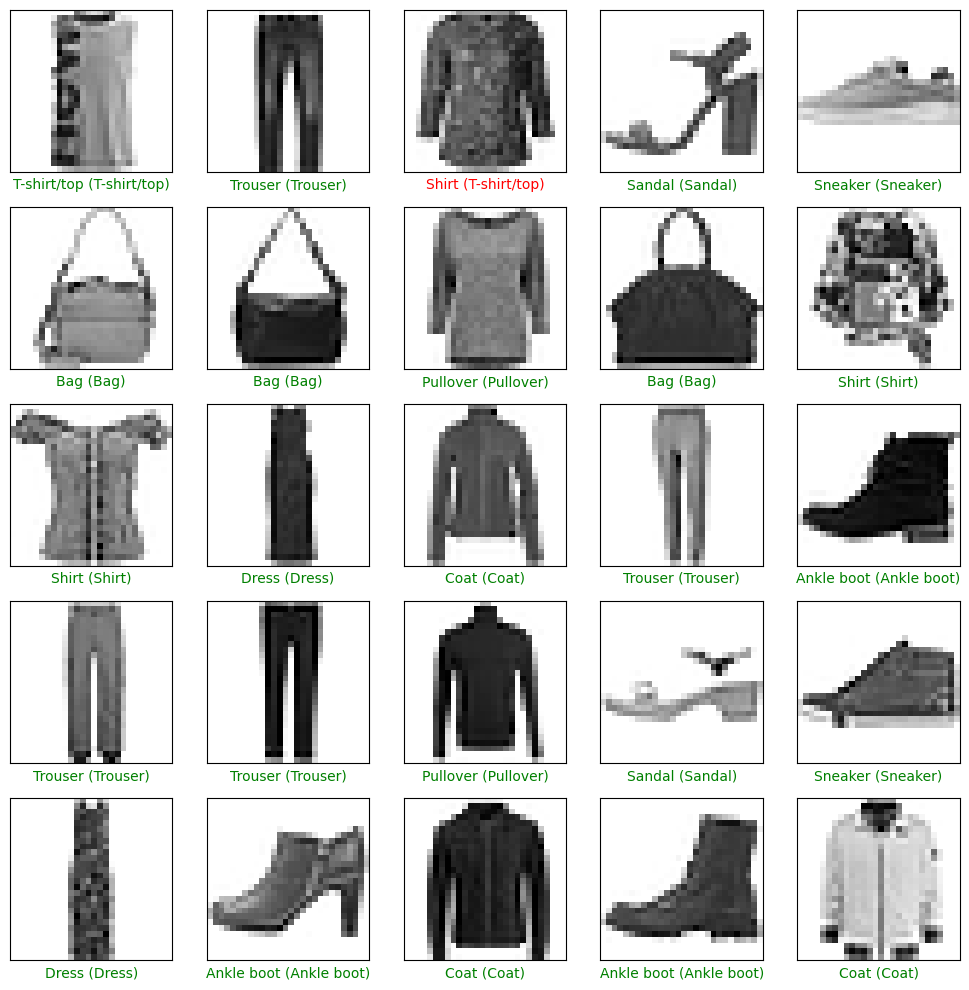

In [13]:
#  Передбачення
y_pred = model.predict(x_test, verbose=0)
#  Виведення точності на тестовому наборі
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Тестова точність: {test_acc:.3%}")
#  Візуалізуємо 25 випадкових зображень і передбачення
figure = plt.figure(figsize=(10, 10))
indices = np.random.choice(len(x_test), size=25, replace=False)

for i, idx in enumerate(indices):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]), cmap=plt.cm.binary)

    pred_idx = np.argmax(y_pred[idx])
    true_idx = y_test[idx]

    ax.set_xlabel(
        f"{class_names[pred_idx]} ({class_names[true_idx]})",
        color=("green" if pred_idx == true_idx else "red"),
    )

plt.tight_layout()
plt.show()

---
# Висновкі
---

1. Базова CNN показала найкращі результати:
Вона проста, але добре узагальнює.

2. Advanced CNN має більше параметрів, але не дала приросту:
Можливо, data augmentation не дало виграшу, бо одяг на зображеннях досить простий.

Також, Dropout 0.2 + 0.2 — можливо, забагато для таких шарів.

3. MLP досяг хороших результатів, але поступається CNN:
Це очікувано: MLP не вловлює просторові зв’язки, як CNN.

In [14]:
# Зберігаємо модель у форматі Keras .h5
model.save("advanced_cnn_model.h5")

# Якщо хочете у форматі TensorFlow SavedModel:
# model.save("advanced_cnn_model")

print("✅ Модель збережена як advanced_cnn_model.h5")

✅ Модель збережена як advanced_cnn_model.h5


In [15]:
model.save("advanced_cnn_model.keras")